In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
#Load Data
df = pd.read_csv('Technical exam data.csv')
df.head()

,POLICY_NUMBER,START_DATE,START_MONTH,CHURN_DATE,MEMBERS,MAX_DURATION,STATE,CARRIER_NAME
0,97662795,01-APR-16,4,01-OCT-16,1,184,AZ,CARRIER2
1,100915150,01-DEC-16,12,01-DEC-16,1,180,OR,CARRIER1
2,99747655,01-OCT-16,10,01-MAR-17,1,180,NC,CARRIER3
3,99406855,01-SEP-16,9,01-JAN-17,1,180,AK,CARRIER3
4,102166525,01-JAN-17,1,01-FEB-17,2,184,AZ,CARRIER2


EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303235 entries, 0 to 303234
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   POLICY_NUMBER  303235 non-null  int64 
 1   START_DATE     303235 non-null  object
 2   START_MONTH    303235 non-null  int64 
 3   CHURN_DATE     303235 non-null  object
 4   MEMBERS        303235 non-null  int64 
 5   MAX_DURATION   303235 non-null  int64 
 6   STATE          303235 non-null  object
 7   CARRIER_NAME   303235 non-null  object
dtypes: int64(4), object(4)
memory usage: 18.5+ MB


In [4]:
#Check null value
df.isnull().sum()

POLICY_NUMBER    0
START_DATE       0
START_MONTH      0
CHURN_DATE       0
MEMBERS          0
MAX_DURATION     0
STATE            0
CARRIER_NAME     0
dtype: int64

In [5]:
#Change date datatype
df['START_DATE'] = pd.to_datetime(df['START_DATE'])
df['CHURN_DATE'] = pd.to_datetime(df['CHURN_DATE'])
df.head()

,POLICY_NUMBER,START_DATE,START_MONTH,CHURN_DATE,MEMBERS,MAX_DURATION,STATE,CARRIER_NAME
0,97662795,2016-04-01,4,2016-10-01,1,184,AZ,CARRIER2
1,100915150,2016-12-01,12,2016-12-01,1,180,OR,CARRIER1
2,99747655,2016-10-01,10,2017-03-01,1,180,NC,CARRIER3
3,99406855,2016-09-01,9,2017-01-01,1,180,AK,CARRIER3
4,102166525,2017-01-01,1,2017-02-01,2,184,AZ,CARRIER2


In [6]:
#Calculate Length
df['LENGTH'] = (df['CHURN_DATE']-df['START_DATE']).dt.days

In [7]:
df['LENGTH'].describe()

count    303235.000000
mean         87.072393
std          97.435005
min        -334.000000
25%          30.000000
50%          61.000000
75%         150.000000
max        1706.000000
Name: LENGTH, dtype: float64

In [8]:
#Drop questionable data (length < 0)
df = df[df['LENGTH']>=0]

In [9]:
#Observe correlation
corr_df = df.corr()
corr_df['LENGTH']

POLICY_NUMBER    0.114158
START_MONTH     -0.031006
MEMBERS         -0.027928
MAX_DURATION     0.239300
LENGTH           1.000000
Name: LENGTH, dtype: float64

Move to Tableau to observe data and create charts

Part 2

In [10]:
#Data Preprocessing
df['START_YEAR'] = df['START_DATE'].dt.year
df['CHURN_YEAR'] = df['CHURN_DATE'].dt.year
df['CHURN_MONTH'] = df['CHURN_DATE'].dt.month

In [11]:
df.head()

,POLICY_NUMBER,START_DATE,START_MONTH,CHURN_DATE,MEMBERS,MAX_DURATION,STATE,CARRIER_NAME,LENGTH,START_YEAR,CHURN_YEAR,CHURN_MONTH
0,97662795,2016-04-01,4,2016-10-01,1,184,AZ,CARRIER2,183,2016,2016,10
1,100915150,2016-12-01,12,2016-12-01,1,180,OR,CARRIER1,0,2016,2016,12
2,99747655,2016-10-01,10,2017-03-01,1,180,NC,CARRIER3,151,2016,2017,3
3,99406855,2016-09-01,9,2017-01-01,1,180,AK,CARRIER3,122,2016,2017,1
4,102166525,2017-01-01,1,2017-02-01,2,184,AZ,CARRIER2,31,2017,2017,2


In [12]:
#Calculate the monthly retention rate
new_user_by_time = df.groupby(['START_DATE','START_YEAR','START_MONTH']).agg(new_user_count=('POLICY_NUMBER','count'))
new_user_by_time = new_user_by_time.reset_index().rename(columns={'START_YEAR':'Year','START_MONTH':'Month'})
churn_by_time = df.groupby(['CHURN_YEAR','CHURN_MONTH']).agg(churn_count=('POLICY_NUMBER','count'))

In [13]:
df_new_user = new_user_by_time.reset_index().rename(columns={'START_YEAR':'Year','START_MONTH':'Month'})
df_churn = churn_by_time.reset_index().rename(columns={'CHURN_YEAR':'Year','CHURN_MONTH':'Month'})
monthly_df = pd.merge(df_new_user, df_churn,  how='inner', left_on=['Year','Month'], right_on = ['Year','Month'])

In [14]:
monthly_df['diff'] = monthly_df['new_user_count']- monthly_df['churn_count']
monthly_df.drop('index', axis =1, inplace=True)

In [15]:
monthly_df['lag'] = monthly_df['diff'].shift(1)
monthly_df['Monthly Retention'] = monthly_df['diff']/monthly_df['lag']
monthly_df.head()

,START_DATE,Year,Month,new_user_count,churn_count,diff,lag,Monthly Retention
0,2015-01-01,2015,1,6723,3002,3721,NaN,NaN
1,2015-02-01,2015,2,5702,2882,2820,3721.0,0.757861
2,2015-03-01,2015,3,5224,3253,1971,2820.0,0.698936
3,2015-04-01,2015,4,5462,3105,2357,1971.0,1.195840
4,2015-05-01,2015,5,5677,3449,2228,2357.0,0.945269


Text(0, 0.5, 'Monthly Retention Rate')

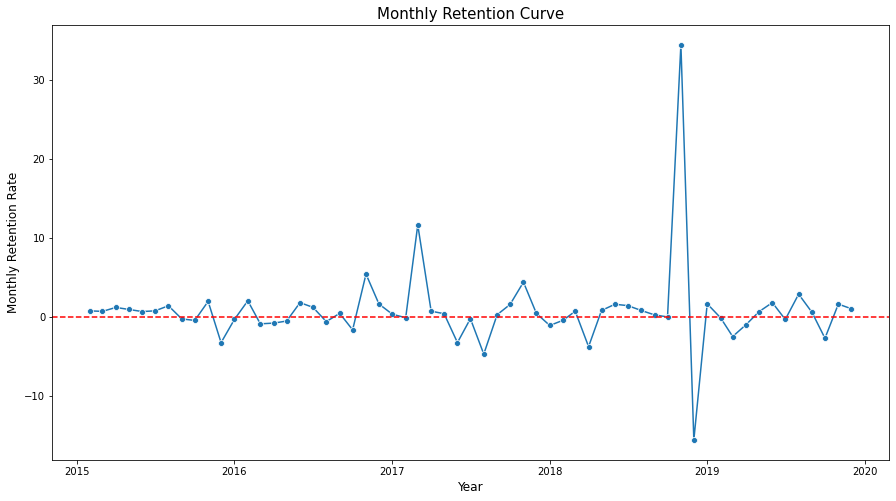

In [16]:
#Plot monthly Retention Curve
fig, ax = plt.subplots(figsize=(15,8))
sns.lineplot(data=monthly_df, y='Monthly Retention', x='START_DATE',marker='o')
plt.axhline(0, color='red', linestyle = '--')
ax.set_title('Monthly Retention Curve', fontsize=15)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Monthly Retention Rate', fontsize=12)

Calculate Cumulative Retention Curve

In [17]:
#New users for each cohort
new_user_by_time = df.groupby('START_DATE').agg(new_user_count=('POLICY_NUMBER','count'))
new_user_by_time = new_user_by_time.reset_index()

In [18]:
new_user_by_time.head()

,START_DATE,new_user_count
0,2015-01-01,6723
1,2015-02-01,5702
2,2015-03-01,5224
3,2015-04-01,5462
4,2015-05-01,5677


In [19]:
#Calculate the 'mon_diff' column (months after cohort start date)
df_t = df[['START_DATE','START_YEAR','START_MONTH','CHURN_YEAR',"CHURN_MONTH"]]
df_t['mon_diff'] = (df_t['CHURN_YEAR'] - df_t['START_YEAR']) * 12 + df_t['CHURN_MONTH'] - df_t['START_MONTH']

<ipython-input-19-272b31290719>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['mon_diff'] = (df_t['CHURN_YEAR'] - df_t['START_YEAR']) * 12 + df_t['CHURN_MONTH'] - df_t['START_MONTH']


In [20]:
group_df = df_t.groupby(['START_DATE','mon_diff']).agg(churn=('START_MONTH','count')).reset_index()

In [21]:
#Calculate cumulative churn users for each cohort in different period
group_df['churn_cumsum'] = group_df.groupby('START_DATE')['churn'].cumsum()

In [22]:
group_df.head()

,START_DATE,mon_diff,churn,churn_cumsum
0,2015-01-01,0,3002,3002
1,2015-01-01,1,1127,4129
2,2015-01-01,2,627,4756
3,2015-01-01,3,295,5051
4,2015-01-01,4,195,5246


In [23]:
#Merge cumulative churn users and new users in different cohorts
whole_df = pd.merge(group_df, new_user_by_time,  how='inner', left_on=['START_DATE'], right_on = ['START_DATE'])

In [24]:
#Calculate Cumulative Retention Rate
whole_df['cumulative_retention_rate'] = (whole_df['new_user_count'] - whole_df['churn_cumsum']) /whole_df['new_user_count']
whole_df.tail()

,START_DATE,mon_diff,churn,churn_cumsum,new_user_count,cumulative_retention_rate
1069,2019-11-01,2,482,964,2439,0.604756
1070,2019-11-01,3,1475,2439,2439,0.000000
1071,2019-12-01,0,197,197,3250,0.939385
1072,2019-12-01,1,559,756,3250,0.767385
1073,2019-12-01,2,2494,3250,3250,0.000000


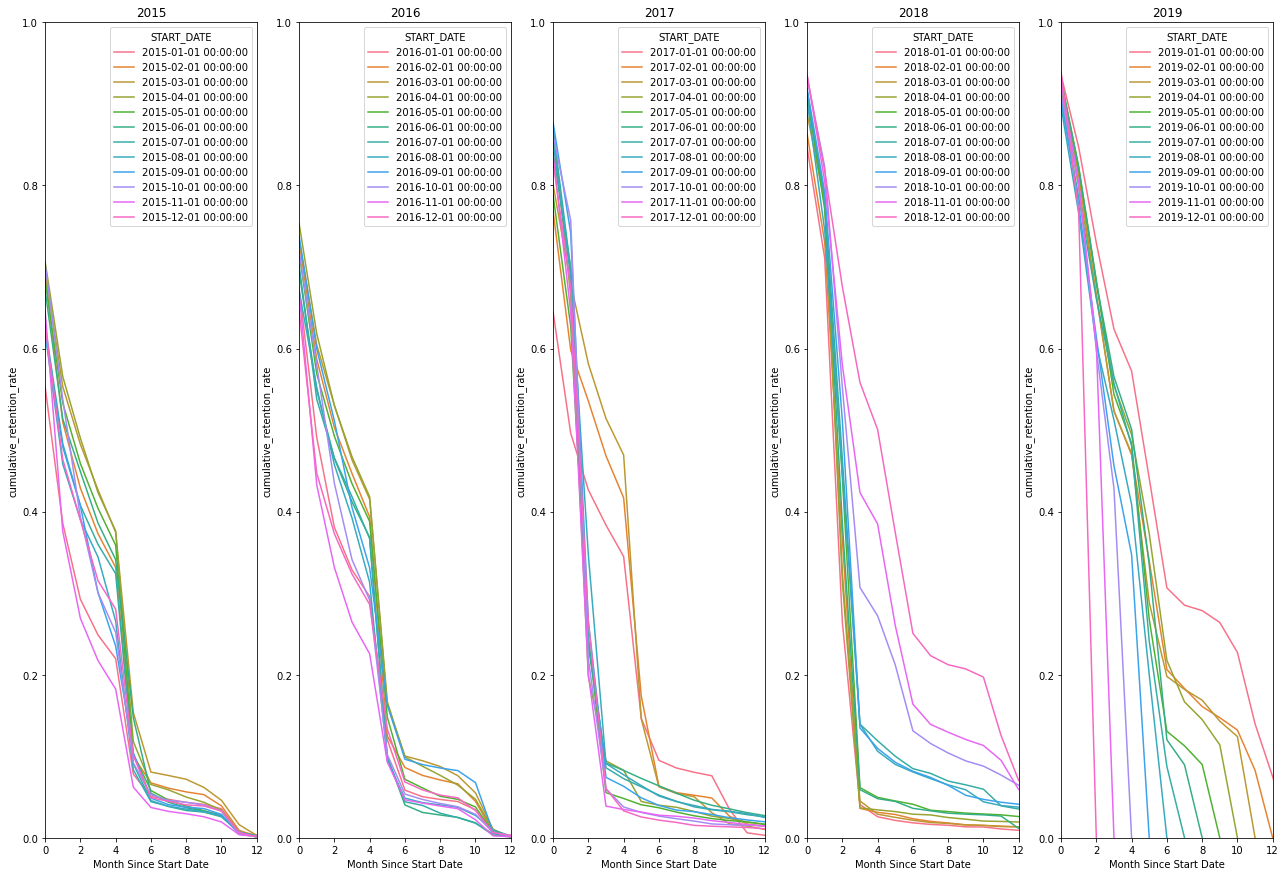

In [25]:
#Plot Cumulative Retention Curve
color_pal = sns.color_palette()
fig, axes = plt.subplots(1, 5, figsize = (22,15))
sns.lineplot(data=whole_df[whole_df['START_DATE'] <'2016-01-01'], x='mon_diff', y='cumulative_retention_rate', hue='START_DATE', ax=axes[0])
sns.lineplot(data=whole_df[(whole_df['START_DATE'] <'2017-01-01') & (whole_df['START_DATE'] >= '2016-01-01')], x='mon_diff', y='cumulative_retention_rate', hue='START_DATE', ax=axes[1])
sns.lineplot(data=whole_df[(whole_df['START_DATE'] <'2018-01-01') & (whole_df['START_DATE'] >= '2017-01-01')], x='mon_diff', y='cumulative_retention_rate', hue='START_DATE', ax=axes[2])
sns.lineplot(data=whole_df[(whole_df['START_DATE'] <'2019-01-01') & (whole_df['START_DATE'] >= '2018-01-01')], x='mon_diff', y='cumulative_retention_rate', hue='START_DATE', ax=axes[3])
sns.lineplot(data=whole_df[whole_df['START_DATE'] >= '2019-01-01'], x='mon_diff', y='cumulative_retention_rate', hue='START_DATE', ax=axes[4])
for i in range(5):
    axes[i].set_xlim([0, 12])
    axes[i].set_ylim([0, 1])
    axes[i].set_title(f'{2015+i}')
    axes[i].set_xlabel('Month Since Start Date')

In [33]:
#Save as csv file
whole_df.to_csv('Cumulate_Retention_Curve.csv')